In [41]:
# import necessary libraries
import pandas as pd
import collections
import numpy as np
import requests
import wikipedia
import re
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from urllib.request import urlopen
from scrapy import selector
import datetime as dt
import pickle
from skimage import io
from IPython.display import clear_output
%matplotlib inline


# scikit learn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier


In [2]:
genre_dict = pickle.load(open("my_data_4/genre_dict","rb"))
all_categories = pickle.load(open("my_data_4/all_categories","rb")) 
major_categories = pickle.load(open("my_data_4/major_categories","rb")) 
minor_categories = pickle.load(open("my_data_4/minor_categories","rb")) 
df_oscars_wide = pd.read_csv('my_data_4/df_oscars_wide.csv', index_col=[0])
df_oscars_wide.title = df_oscars_wide.title.str.replace(':','')

award_columns = list(df_oscars_wide.columns[1:-1])
print('Award columns:\n', award_columns)

df_movies_main = pd.read_csv('my_data_4/DF_MEGA.csv',index_col=[0])
df_movies_main = df_movies_main[df_movies_main.imdbID.duplicated()==False]
df_movies_main.drop(['book','other','none'], axis=1, inplace=True)

df_movies_main_2019 = pd.read_csv('my_data_4/DF_MEGA_2019_updated.csv',index_col=[0])
filters_2019 = (df_movies_main_2019.dra==1)|(df_movies_main_2019.com==1)|(df_movies_main_2019.rom==1)|(df_movies_main_2019.epi==1)
filters_2019 = filters_2019 & (df_movies_main_2019.act==0)
df_movies_main_2019 = df_movies_main_2019[filters_2019]


# Only consider post 1960 movies
df_oscars_wide = df_oscars_wide[df_oscars_wide.year >= 1960]
df_movies_main = df_movies_main[df_movies_main.year >= 1960]

df_movies_main.title = df_movies_main.title.str.replace(':','')

print(df_movies_main.shape)
print(df_movies_main_2019.shape)
print("\nColumns:\n", df_movies_main.columns)
df_movies_main.head()


Award columns:
 ['actor', 'actress', 'art_direction', 'cinematography', 'costume', 'director', 'editing', 'effects', 'music', 'picture', 's_actor', 's_actress', 'screenplay', 'song', 'sound']
(4581, 49)
(157, 50)

Columns:
 Index(['imdbID', 'title', 'year', 'n_votes', 'imdb_rating', 'budget',
       'box_office', 'cast', 'genre', 'running_time', 'inflation_factor',
       'budget_adjusted', 'budget_per_actor', 'budget_per_time',
       'runtime_per_actor', 'percent_revenue', 'total_ratings', 'sup', 'hor',
       'com', 'spy', 'his', 'war', 'psy', 'rom', 'mon', 'fan', 'mus', 'pol',
       'bio', 'sci', 'act', 'dra', 'dis', 'adv', 'mys', 'thr', 'dys', 'cri',
       'epi', 'oth', 'ani', 'based_on_book', 'prescore', 'postscore',
       'precount_wins', 'precount_noms', 'win', 'nom'],
      dtype='object')


,imdbID,title,year,n_votes,imdb_rating,budget,box_office,cast,genre,running_time,...,epi,oth,ani,based_on_book,prescore,postscore,precount_wins,precount_noms,win,nom
0,tt0097626,johnny handsome,1989,8324,6.2,20.0,7.24,7,3,96,...,0,0,0,1.0,0.4,0.0,0,2,0,0
1,tt0120903,x-men,2000,545484,7.4,75.0,296.30,10,4,104,...,0,0,0,1.0,5.4,0.0,1,2,0,0
2,tt0077975,national lampoon's animal house,1978,106817,7.5,3.0,141.60,6,1,109,...,0,0,0,0.0,0.0,0.0,0,0,0,0
3,tt1649419,the impossible,2012,182949,7.6,45.0,198.10,3,3,113,...,0,0,0,0.0,0.2,0.2,0,1,0,1
4,tt1099212,twilight,1998,401686,5.2,385.0,3346.00,18,3,607,...,0,0,0,1.0,0.0,0.0,0,0,0,0


In [4]:
# df_outcome = df_movies_main[['imdbID','title','year']]
df_movies_main = df_movies_main.merge(df_oscars_wide, on = ['title'], how='left').drop(columns='year_y').rename(columns = {'year_x':'year'})
df_movies_main.fillna('O', inplace=True)
df_movies_main = df_movies_main[df_movies_main.imdbID.duplicated()==False]

# Split into Data and Outcome
df_outcome = df_movies_main[['title'] + award_columns]
df_movies_main.drop(award_columns, axis=1, inplace=True)

print(df_movies_main.shape)
print(df_outcome.shape)
df_movies_main.tail()

(4581, 49)
(4581, 16)


,imdbID,title,year,n_votes,imdb_rating,budget,box_office,cast,genre,running_time,...,epi,oth,ani,based_on_book,prescore,postscore,precount_wins,precount_noms,win,nom
4583,tt0452624,the good german,2006,23319,6.0,32.0,6.0,3,4,105,...,0,0,0,1.0,10.700000,0.0,3,7,0,0
4584,tt0497116,an inconvenient truth,2006,78298,7.4,1.5,49.8,1,2,97,...,0,0,0,0.0,0.400000,0.0,0,2,0,0
4585,tt0857191,the visitor,2008,40468,7.6,4.0,18.1,4,1,103,...,0,0,0,0.0,0.200000,0.2,0,1,0,1
4586,tt1667353,mirror mirror,2012,80479,5.6,85.0,183.0,7,5,106,...,0,1,0,1.0,5.800000,0.0,1,4,0,0
4587,tt4226388,victoria & abdul,2017,46625,7.7,21.0,65.4,6,5,111,...,0,0,0,1.0,7.136111,0.0,1,12,0,0


In [5]:
df_movies_main.columns

Index(['imdbID', 'title', 'year', 'n_votes', 'imdb_rating', 'budget',
       'box_office', 'cast', 'genre', 'running_time', 'inflation_factor',
       'budget_adjusted', 'budget_per_actor', 'budget_per_time',
       'runtime_per_actor', 'percent_revenue', 'total_ratings', 'sup', 'hor',
       'com', 'spy', 'his', 'war', 'psy', 'rom', 'mon', 'fan', 'mus', 'pol',
       'bio', 'sci', 'act', 'dra', 'dis', 'adv', 'mys', 'thr', 'dys', 'cri',
       'epi', 'oth', 'ani', 'based_on_book', 'prescore', 'postscore',
       'precount_wins', 'precount_noms', 'win', 'nom'],
      dtype='object')

In [6]:
# # 'A star is born' and 'True grit' were duplicated
# df_outcome.drop(index = 235,inplace=True)
# df_outcome[df_outcome.title.str.startswith('a star is born')]
# df_outcome.drop(index = 492,inplace=True)
# df_outcome[df_outcome.title.str.startswith('true grit')]

In [88]:
df_movies_main_2019.sort_values(by='box_office_adjusted', ascending=False).head()

,imdbID,title,year,n_votes,imdb_rating,budget,box_office,cast,genre,running_time,...,oth,ani,based_on_book,other,prescore,postscore,precount_wins,precount_noms,box_office_adjusted,predicted_probability
1,tt1979376,toy story 4,2019,135006,7.9,200.0,1073.0,13.0,3,100.0,...,0,1,0.0,0.0,16.5,0.0,3,9,420.784314,0.405562
131,tt7286456,joker,2019,513667,8.7,70.0,1061.0,1.0,4,122.0,...,0,0,1.0,0.0,1.3,0.0,0,8,416.078431,0.503602
5,tt0103639,aladdin,2019,339486,8.0,183.0,1051.0,7.0,4,128.0,...,0,0,1.0,0.0,0.4,0.0,0,2,412.156863,0.410956
4,tt4520988,frozen ii,2019,12874,7.3,150.0,1041.0,4.0,5,103.0,...,0,1,0.0,0.0,0.0,0.0,0,0,408.235294,0.400962
6,tt7349950,it chapter two,2019,127076,6.7,79.0,472.1,8.0,3,169.0,...,0,0,1.0,0.0,0.4,0.0,0,2,185.137255,0.403666


# Learning from the Data

In [7]:
basic_ID_columns = ['imdbID', 'title', 'year']
genre_columns = ['genre', 'spy', 'sup', 'hor', 'dys', 'thr', 'act',
       'his', 'adv', 'dis', 'epi', 'com', 'fan', 'ani', 'mys', 'dra', 'psy',
       'mon', 'war', 'sci', 'mus', 'cri', 'oth', 'pol', 'rom', 'bio',
       'based_on_book']
imdb_columns = ['cast', 'n_votes', 'imdb_rating']
pre_oscar_columns = ['prescore', 'precount_wins', 'precount_noms']
post_oscar_columns = ['postscore', 'win', 'nom']
derived_columns = ['budget_per_actor', 'budget_per_time',
       'runtime_per_actor', 'percent_revenue', 'total_ratings']
budget_columns = ['budget', 'inflation_factor','budget_adjusted']
box_office_columns = ['box_office']


In [8]:
def convert_to_pctile(X):
    for col in X.columns:
        x = np.array(X[col])
        X[col] = [(len(np.where(x<=y)[0])/len(x)) for y in x]
    return X

def top_N_each_year(df,N,feature):
    df_ = pd.DataFrame()
    for year in list(set(df.year)):
        # print(year)
        df_ = df_.append(df[df.year == year].sort_values(by = feature, ascending=False).head(N))
    return df_

## K Nearest Neighbor Classifier 

We use a KNN classifier to predict the outcome of the 2019 movies. 

In [9]:
print(df_outcome.shape)
df_outcome.head()

(4581, 16)


,title,actor,actress,art_direction,cinematography,costume,director,editing,effects,music,picture,s_actor,s_actress,screenplay,song,sound
0,johnny handsome,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
1,x-men,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
2,national lampoon's animal house,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
3,the impossible,O,N,O,O,O,O,O,O,O,O,O,O,O,O,O
4,twilight,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O


In [10]:
#Define predictors
all_predictors = ['imdbID', 'title', 'year', 'imdb_rating',
       'cast', 'precount_wins', 'precount_noms', 'prescore', 'running_time']  + genre_columns # +  ['percent_revenue']

# Get training ad testing data
X = df_movies_main[all_predictors].drop(['imdbID', 'title', 'year'], axis=1)
X_2019 = df_movies_main_2019[all_predictors].drop(['imdbID', 'title', 'year'], axis=1)
print(X.shape)
print(X_2019.shape)

# Target
y = (df_outcome.picture == 'N') | (df_outcome.director== 'N')
y = np.array([int(z) for z in y])
print(y.shape)
y = np.expand_dims(y, axis=1)
print("Number of movies in the 1-class:,",len(np.where(y==1)[0]))

# Copnvert to Percentile
X = convert_to_pctile(X)
X_2019 = convert_to_pctile(X_2019)

(4581, 33)
(157, 33)
(4581,)
Number of movies in the 1-class:, 292


## K Nearest neighbors classifier

{'n_neighbors': 10}


<BarContainer object of 10 artists>

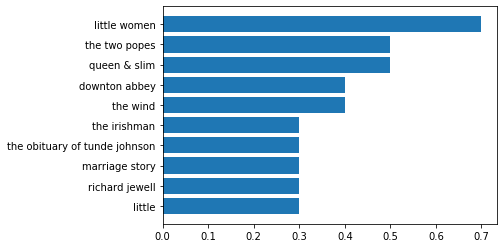

In [100]:

# KNN Training
knn = KNeighborsClassifier(n_neighbors=5)
param_grid = {'n_neighbors': np.arange(1, 30)} 
knn_cv = GridSearchCV(knn, param_grid, cv=5) 
# knn.fit(X, y) 
knn_cv.fit(X, y)

# KNN prediction
y_pred = knn_cv.predict(X_2019)
y_prob = knn_cv.predict_proba(X_2019)
df_movies_main_2019.loc[:,'predicted_probability_knn'] = y_prob[:,1]
clear_output()
x = df_movies_main_2019.sort_values(by='predicted_probability_knn', ascending=False).head(10)
print(knn_cv.best_params_)
x = x.iloc[::-1,:]
plt.barh(x['title'], x['predicted_probability_knn'])


## Random Forest Classifier

{'n_estimators': 55}


<BarContainer object of 10 artists>

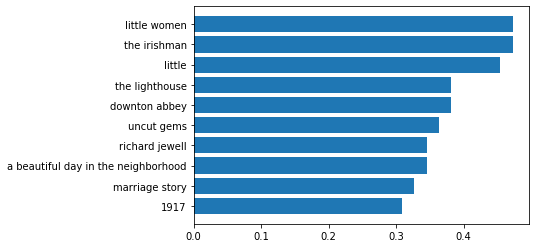

In [105]:
rfc=RandomForestClassifier() # n_estimators=100)
param_grid = {'n_estimators': np.arange(50,100,5)} 
rfc_cv = GridSearchCV(rfc, param_grid, cv=5) 

rfc_cv.fit(X,y)
y_pred = rfc_cv.predict(X_2019)
y_prob = rfc_cv.predict_proba(X_2019)
df_movies_main_2019.loc[:,'predicted_probability_rfc'] = y_prob[:,1]
clear_output()
x = df_movies_main_2019.sort_values(by='predicted_probability_rfc', ascending=False).head(10)
print(rfc_cv.best_params_)
x = x.iloc[::-1,:]
plt.barh(x['title'], x['predicted_probability_rfc'])


### Decision Tree Regressor

In [106]:
sample_split = list(range(2, 20))
param_grid = dict(min_samples_split=sample_split)
reg = DecisionTreeRegressor(random_state = 47)
reg_cv = GridSearchCV(reg, param_grid, cv=5) 
reg_cv.fit(X,y)
y_pred=reg_cv.predict(X_2019)
# y_prob = reg_cv.predict_proba(X_2019)
# df_movies_main_2019.loc[:,'predicted_probability'] = y_prob[:,1]
# df_movies_main_2019[['imdbID','title','year','predicted_probability']][y_pred == 1].sort_values(by = 'predicted_probability',
                                                                                               # ascending=False)

df_movies_main_2019[['imdbID','title','year']][y_pred == 1]

,imdbID,title,year
145,tt2584384,jojo rabbit,2019
156,tt7653254,marriage story,2019


## Ensemble Method

<BarContainer object of 10 artists>

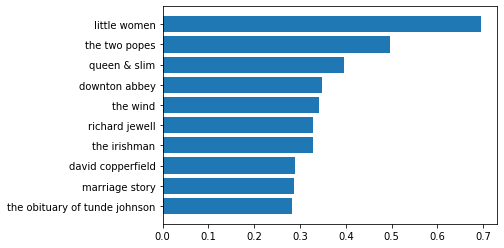

In [109]:
bag = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=10), n_estimators=100, random_state=42).fit(X, y)
y_pred = bag.predict(X_2019)
y_prob = bag.predict_proba(X_2019)
df_movies_main_2019.loc[:,'predicted_probability_bag'] = y_prob[:,1]
clear_output()
x = df_movies_main_2019.sort_values(by='predicted_probability_bag', ascending=False).head(10)
x = x.iloc[::-1,:]
plt.barh(x['title'], x['predicted_probability_bag'])


# Adaboost

<BarContainer object of 10 artists>

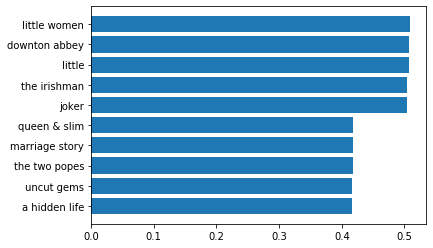

In [111]:
ada = AdaBoostClassifier(n_estimators=100, random_state=47)
ada.fit(X, y)
y_pred = ada.predict(X_2019)
y_prob = ada.predict_proba(X_2019)

df_movies_main_2019.loc[:,'predicted_probability_ada'] = y_prob[:,1]
clear_output()
x = df_movies_main_2019.sort_values(by='predicted_probability_ada', ascending=False).head(10)
# print(bag.best_params_)
x = x.iloc[::-1,:]
plt.barh(x['title'], x['predicted_probability_ada'])

# Neural Network

<BarContainer object of 10 artists>

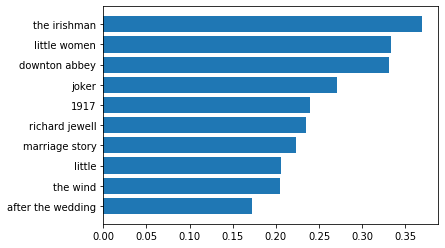

In [112]:
mlp = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(5,5), max_iter=1000, random_state=41)
mlp.fit(X, y)
y_pred = mlp.predict(X_2019)
y_prob = mlp.predict_proba(X_2019)
# print(y_prob)
# print(classifier.score)
df_movies_main_2019.loc[:,'predicted_probability_mlp'] = y_prob[:,1]
clear_output()
x = df_movies_main_2019.sort_values(by='predicted_probability_mlp', ascending=False).head(10)
# print(bag.best_params_)
x = x.iloc[::-1,:]
plt.barh(x['title'], x['predicted_probability_mlp'])

# Ensemble of Neural Networks

<BarContainer object of 10 artists>

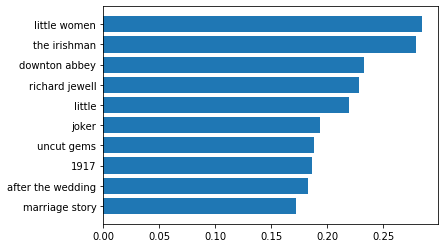

In [113]:
mlp = MLPClassifier(solver='sgd')
mlp_bag = BaggingClassifier(base_estimator=mlp, n_estimators=100, random_state=42).fit(X, y)
y_pred = mlp_bag.predict(X_2019)
y_prob = mlp_bag.predict_proba(X_2019)
df_movies_main_2019.loc[:,'predicted_probability_mlpbag'] = y_prob[:,1]
clear_output()
x = df_movies_main_2019.sort_values(by='predicted_probability_mlpbag', ascending=False).head(10)
# print(bag.best_params_)
x = x.iloc[::-1,:]
plt.barh(x['title'], x['predicted_probability_mlpbag'])



# df_movies_main_2019.loc[:,'predicted_probability_mlpbag'] = y_prob[:,1]
# # df_movies_main_2019[['imdbID','title','year','predicted_probability']][y_pred == 1]
# df_movies_main_2019[['imdbID','title','year','predicted_probability']].sort_values(by = 'predicted_probability',
#                                                                                                ascending=False)
# clear_output()
# df_movies_main_2019[['imdbID','title','year','predicted_probability']].sort_values(by = 'predicted_probability',
#                                                                                    ascending=False).head(10)
                                                                                   

In [114]:
df_movies_main_2019.columns

Index(['imdbID', 'title', 'year', 'n_votes', 'imdb_rating', 'budget',
       'box_office', 'cast', 'genre', 'running_time', 'inflation_factor',
       'budget_adjusted', 'budget_per_actor', 'budget_per_time',
       'runtime_per_actor', 'percent_revenue', 'total_ratings', 'book', 'sup',
       'hor', 'com', 'spy', 'his', 'war', 'psy', 'rom', 'mon', 'fan', 'mus',
       'pol', 'bio', 'sci', 'act', 'dra', 'dis', 'adv', 'mys', 'thr', 'dys',
       'cri', 'epi', 'oth', 'ani', 'based_on_book', 'other', 'prescore',
       'postscore', 'precount_wins', 'precount_noms', 'box_office_adjusted',
       'predicted_probability', 'predicted_probability_rfc',
       'predicted_probability_knn', 'predicted_probability_bag',
       'predicted_probability_ada', 'predicted_probability_mlp',
       'predicted_probability_mlpbag'],
      dtype='object')

# The Grand Average Prediction

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

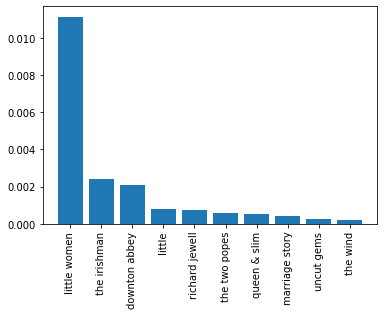

In [124]:
df_movies_main_2019['final_proba'] = df_movies_main_2019[['predicted_probability_rfc',
       'predicted_probability_knn', 'predicted_probability_bag',
       'predicted_probability_ada', 'predicted_probability_mlp',
       'predicted_probability_mlpbag']].prod(axis=1)
df_movies_main_2019.columns
x = df_movies_main_2019.sort_values(by='final_proba', ascending=False).head(10)
# print(bag.best_params_)
# x = x.iloc[::-1,:]
plt.bar(x['title'], x['final_proba'])
plt.xticks(rotation=90)
